# Preparation

The first few cells are only needed for the loading of the dataset and the model which decisions we want to interpret. The `DeepLIFT` specific logic resides in the later cells.

In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from nn_interpretability.model.model_trainer import ModelTrainer
from nn_interpretability.model.model_repository import ModelRepository
from nn_interpretability.interpretation.deeplift.deeplift import DeepLIFT, DeepLIFTRules
from nn_interpretability.visualization.mnist_visualizer import MnistVisualizer
from nn_interpretability.dataset.mnist_data_loader import MnistDataLoader

In [2]:
mnist_data_loader = MnistDataLoader()

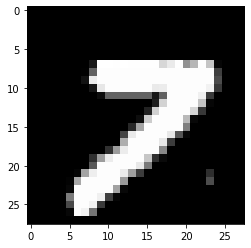

In [3]:
MnistVisualizer.show_dataset_examples(mnist_data_loader.trainloader)

In [4]:
model_name = 'model_cnn.pt'

train = False

In [5]:
model = ModelRepository.get_general_mnist_cnn(model_name)

if train:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    model.train()
    ModelTrainer.train(model, criterion, optimizer, trainloader)
    
    ModelRepository.save(model, model_name)

# DeepLIFT

DeepLIFT has been introduced in the paper "Learning Important Features Through Propagating Activation Differences" by Shrikumar et al. and is a decision-based interpretabiltiy method which tries to explain a prediction by asssigning contribution scores through leveraging the difference to a reference input and output. The paper can be found [here.](https://arxiv.org/pdf/1704.02685.pd) More in-depth notes can be found in the `research/notes/notes_deeplift.md` markdown.

Our implementation of DeepLIFT can found in the class `DeepLIFT` residing in the `nn_interpretability` package. We have implemented the `Linear` rule for `Linear` layers and the `RevealCancel` and `Rescale` rules for `ReLU` layers. The rules can either be used separately or in combination with one another. The configuration of the `DeepLIFT` happens through its constructor parameters. The constructor parameter `rule` should be used to specify which rule(s) are to be used. The available values are defined in the `DeepLIFTRules` enumeration. The following table showcases what every enum value means.

| DeepLIFTRule | Explanation  |
|---|---|
| NoRule  | No rules, the result is a simple vanilla backpropagation.  |
| Rescale  |  Only the Rescale rule for ReLU layers is applied. |
| RevealCancel  | Only the RevealCancel rule for ReLU layers is applied. |
| Linear  | Only the Linear rule for Linear layers is applied.  |
| LinearRescale  |  Linear rule is used for Linear layers and Rescale rule is used for ReLU layers. |
| LinearRevealCancel  | Linear rule is used for Linear layers and RevealCancel rule is used for ReLU layers. |

<b>Important is to mention, that whenever a `DeepLIFT` object is no longer needed, the `cleanup()` method should be invoked to remove any hooks which have been attached to layers of the given model!<b>

In [6]:
def execute_deep_lift(model, data_loader, rule):
    interpreter = DeepLIFT(model, [str(i) for i in range(10)], None, rule)

    images = []

    for i in range(10):
        img = data_loader.get_image_for_class(i)
        out = interpreter.interpret(img)
        out = (out - out.min()) / (out.max() - out.min()) 
        images.append(out.numpy().reshape(28, 28))
    print("RULE: " + rule.name)
    interpreter.cleanup()
    MnistVisualizer.display_images_for_each_class(images)
    plt.show()

## 1. DeepLIFT NoRule

In this case we are simply executing a vanilla backpropagation. This rules is only meant as a reference point to the other results.

RULE: NoRule


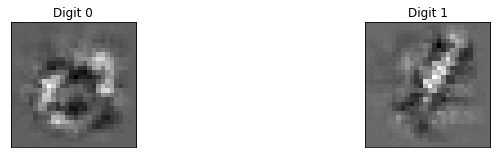

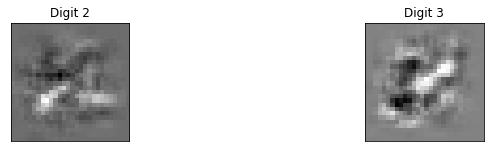

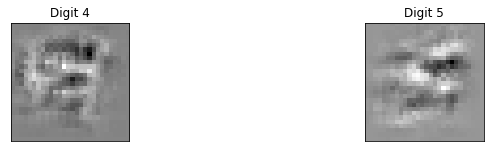

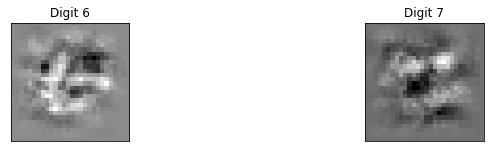

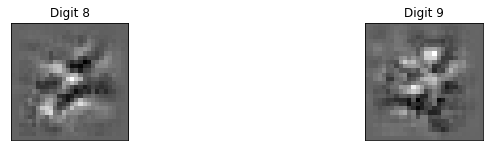

In [7]:
execute_deep_lift(model, mnist_data_loader, DeepLIFTRules.NoRule)

## 2. DeepLIFT Rescale

The `Rescale` rule is used for `ReLU` layers. Here we compute the contributions as follows:
<br>
<center>
  <p float="left">
    <img src="./assets/deeplift_rescale_formula.png"/>
  </p>
</center>

The multipliers have as a consequence the following form:

<center>
  <p float="left">
    <img src="./assets/deeplift_multiplier_formula.png"/>
  </p>
</center>

In the places, where the values are close to their reference counterparts, numerical instability can be observed due to division by either 0 or extremely small value. In these cases, the gradient instead of the multiplier can be used. 

RULE: Rescale


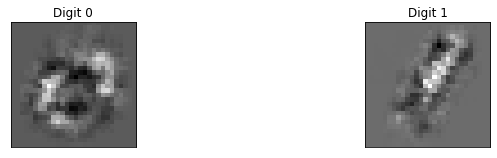

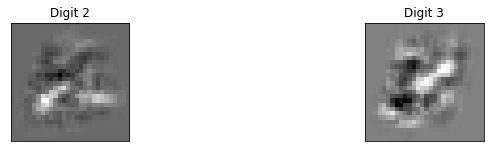

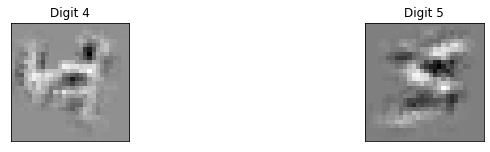

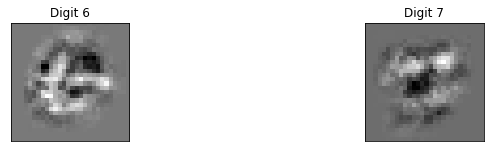

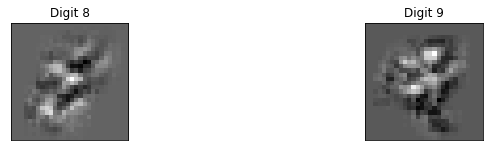

In [8]:
execute_deep_lift(model, mnist_data_loader, DeepLIFTRules.Rescale)

## 3. DeepLIFT RevealCancel

The `RevealCancel` rule also targets `ReLU` layers, but unlike the `Rescale` rule it handles the positive and negative contributions in different ways. Here we compute the contributions as follows:

![RevealCancel Formula](./assets/deeplift_revealcancel_formula.png)

In short, for the positive output contributions we are trying to figure out the average impact of the positive delta input after no terms has been added and after the negative delta input has been added. The same operation is done for the negative output contributions, but in this case, we compute the impact of the negative delta input without any added terms and after the positive delta input have been added.

RULE: RevealCancel


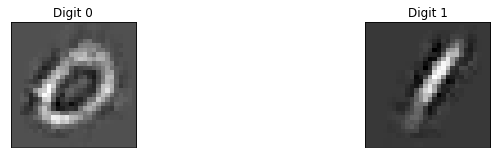

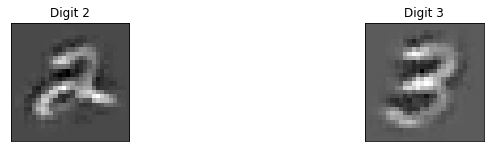

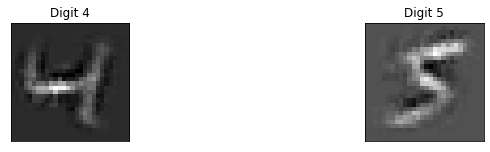

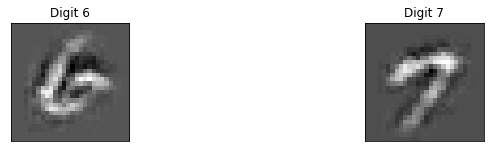

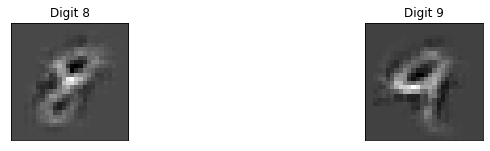

In [9]:
execute_deep_lift(model, mnist_data_loader, DeepLIFTRules.RevealCancel)

## 4. DeepLIFT Linear

In our implementation, the `Linear` rule has been applied only to `Linear` layers. Here the contributions are being computed in the following fashion:

<br>
<center>
  <p float="left">
    <img src="./assets/deeplift_linear_formula.png"/>
  </p>
</center>

RULE: Linear


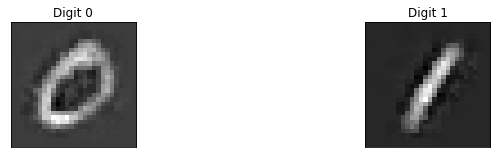

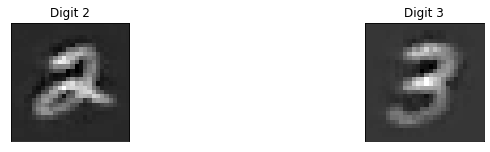

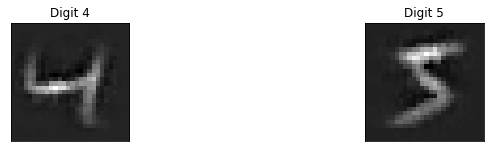

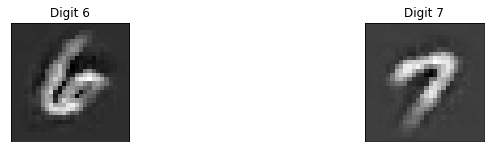

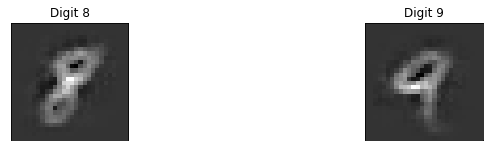

In [10]:
execute_deep_lift(model, mnist_data_loader, DeepLIFTRules.Linear)

## 5. DeepLIFT LinearRescale

In this case, we are using both the `Linear` and `Rescale` rules together.

RULE: LinearRescale


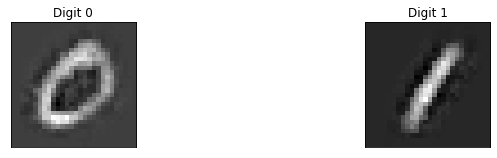

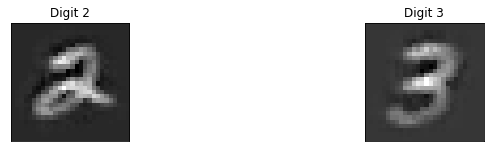

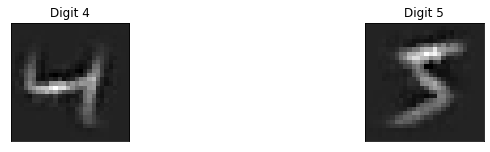

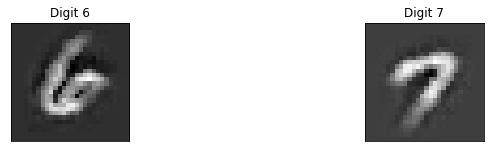

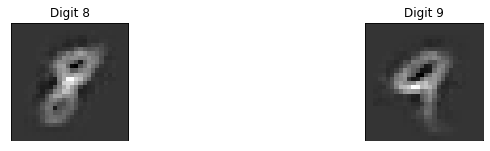

In [11]:
execute_deep_lift(model, mnist_data_loader, DeepLIFTRules.LinearRescale)

## 6. DeepLIFT LinearRevealCancel

In this case, we are using both the `Linear` and `RevealCancel` rules together.

RULE: LinearRevealCancel


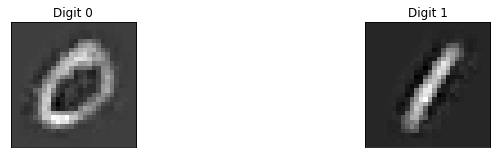

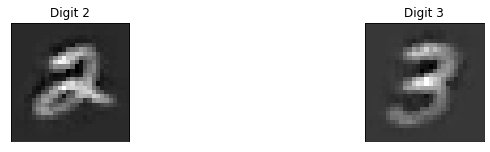

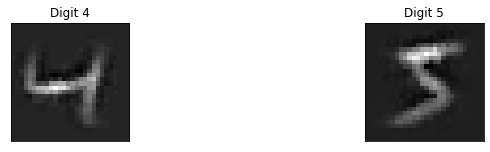

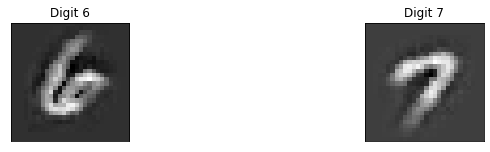

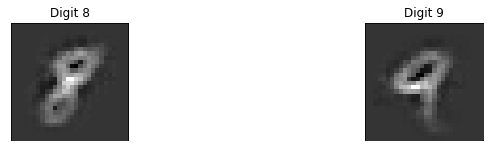

In [12]:
execute_deep_lift(model, mnist_data_loader, DeepLIFTRules.LinearRevealCancel)